In [1]:
import torch
import numpy as np
from spin import create_J_matrix, SpinConfiguration
from modeling import IsingEnergyModel
import matplotlib.pyplot as plt

### Simple model from previous notebook

In [2]:
class IsingSimpleFlowModel(torch.nn.Module):
    def __init__(self, N, n_hidden=256):
        super().__init__()
        
        self.N = N
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2 * self.N**2, n_hidden),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(n_hidden, 2 * self.N**2))
        
    def forward(self, state):
        mask = torch.cat([state[:,:N**2] + state[:,N**2:]]*2, dim=-1)
        probs = self.net(state).exp() * (1 - mask)
        return probs
    
    def make_choice(self, state):
        probs = self(state)
        choice = torch.distributions.categorical.Categorical(probs=probs).sample()
        new_state = state.clone()
        new_state[torch.arange(new_state.shape[0], dtype=torch.int64), choice] = 1
        return new_state

### Training

In [3]:
def create_empty_state(N):
    return torch.zeros(2*(N**2), dtype=torch.float32,requires_grad=True)

def create_input_batch(N, batch_size):
    return torch.cat([create_empty_state(N).reshape(1,-1)] * batch_size, dim=0)  

In [4]:
def get_parent_states_and_actions(batch):
    parents_states, parent_actions = [], []
    
    for state in batch:
        parents, actions = [], []
        chosen_spins = torch.where(state==1)
        for index in chosen_spins[0]:
            tmp_state = state.clone()
            tmp_state[index] = 0
            parents.append(tmp_state)
            actions.append(index)
        parents_states.append(torch.stack(parents))
        parent_actions.append(torch.stack(actions))
    parents_states = torch.stack(parents_states)
    parent_actions = torch.stack(parent_actions)
    return parents_states, parent_actions

In [7]:
N = 3
batch_size = 1
J = create_J_matrix(N, sigma=1)
model = IsingSimpleFlowModel(N=N)
energy_model = IsingEnergyModel(J=J)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
MAX_TRAJECTORIES = 10000
n_traj = 0
n_batches = 0
rewards = []

while n_traj < MAX_TRAJECTORIES:
    batch = create_input_batch(N=N, batch_size=batch_size)
    n_traj += batch_size
    loss = 0
    
    for step in range(N**2):
        new_batch = model.make_choice(batch)
        parent_states, parent_actions = get_parent_states_and_actions(new_batch)
        
        parents_flow_in = []
        for ps, pa in zip(parent_states, parent_actions):
            parents_flow_in.append(model(ps)[torch.arange(len(ps)), pa].sum())
        parents_flow_in = torch.stack(parents_flow_in)
        
        if step < N**2 - 1:
            reward = 0
            child_flow_out = model(new_batch).sum(dim=1)
        elif step == N**2 - 1:
            reward = energy_model.get_reward(new_batch)
            rewards.append(reward.item())
            child_flow_out = 0

        flow_mismatch = (parents_flow_in - child_flow_out - reward)
        loss += torch.mean(flow_mismatch.pow(2))
        batch = new_batch
    
    batch_loss = torch.mean(loss)
    if n_batches%200==0:
        print("----n_traj: ", n_traj)
        print("Loss: ", loss)
    n_batches += 1
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

----n_traj:  1
Loss:  tensor(2976.4429, grad_fn=<AddBackward0>)
----n_traj:  201
Loss:  tensor(1460.8715, grad_fn=<AddBackward0>)
----n_traj:  401
Loss:  tensor(37522.5898, grad_fn=<AddBackward0>)
----n_traj:  601
Loss:  tensor(1436.6062, grad_fn=<AddBackward0>)
----n_traj:  801
Loss:  tensor(13155.3486, grad_fn=<AddBackward0>)
----n_traj:  1001
Loss:  tensor(16033.1543, grad_fn=<AddBackward0>)
----n_traj:  1201
Loss:  tensor(1262.5890, grad_fn=<AddBackward0>)
----n_traj:  1401
Loss:  tensor(33177.1992, grad_fn=<AddBackward0>)
----n_traj:  1601
Loss:  tensor(8020.6504, grad_fn=<AddBackward0>)
----n_traj:  1801
Loss:  tensor(16171.2021, grad_fn=<AddBackward0>)
----n_traj:  2001
Loss:  tensor(4780.3340, grad_fn=<AddBackward0>)
----n_traj:  2201
Loss:  tensor(8675.4160, grad_fn=<AddBackward0>)
----n_traj:  2401
Loss:  tensor(1145.4874, grad_fn=<AddBackward0>)
----n_traj:  2601
Loss:  tensor(8541.9570, grad_fn=<AddBackward0>)
----n_traj:  2801
Loss:  tensor(499.1973, grad_fn=<AddBackward0>

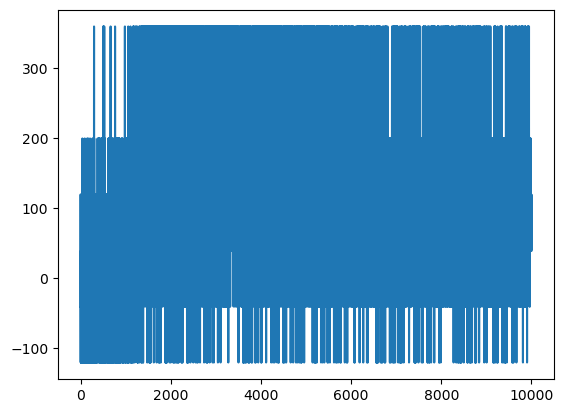

In [9]:
plt.plot(rewards)

In [10]:
def spin_to_state(spin):
    N = spin.values.shape[0]
    state = torch.zeros((2*(N**2)))
    state[:N**2][torch.where(spin.values.flatten()==1)] = 1
    state[N**2:][torch.where(spin.values.flatten()==-1)] = 1
    return state

def state_to_spin(state):
    N = int(np.sqrt(state.shape[0]/2))
    values = torch.zeros(N**2, dtype=torch.float32)
    values[torch.where(state[:N**2]==1)] = 1
    values[torch.where(state[N**2:]==1)] = -1
    spin = SpinConfiguration(N, values.reshape(N, N))
    return spin

tensor(377.9176, grad_fn=<MulBackward0>)


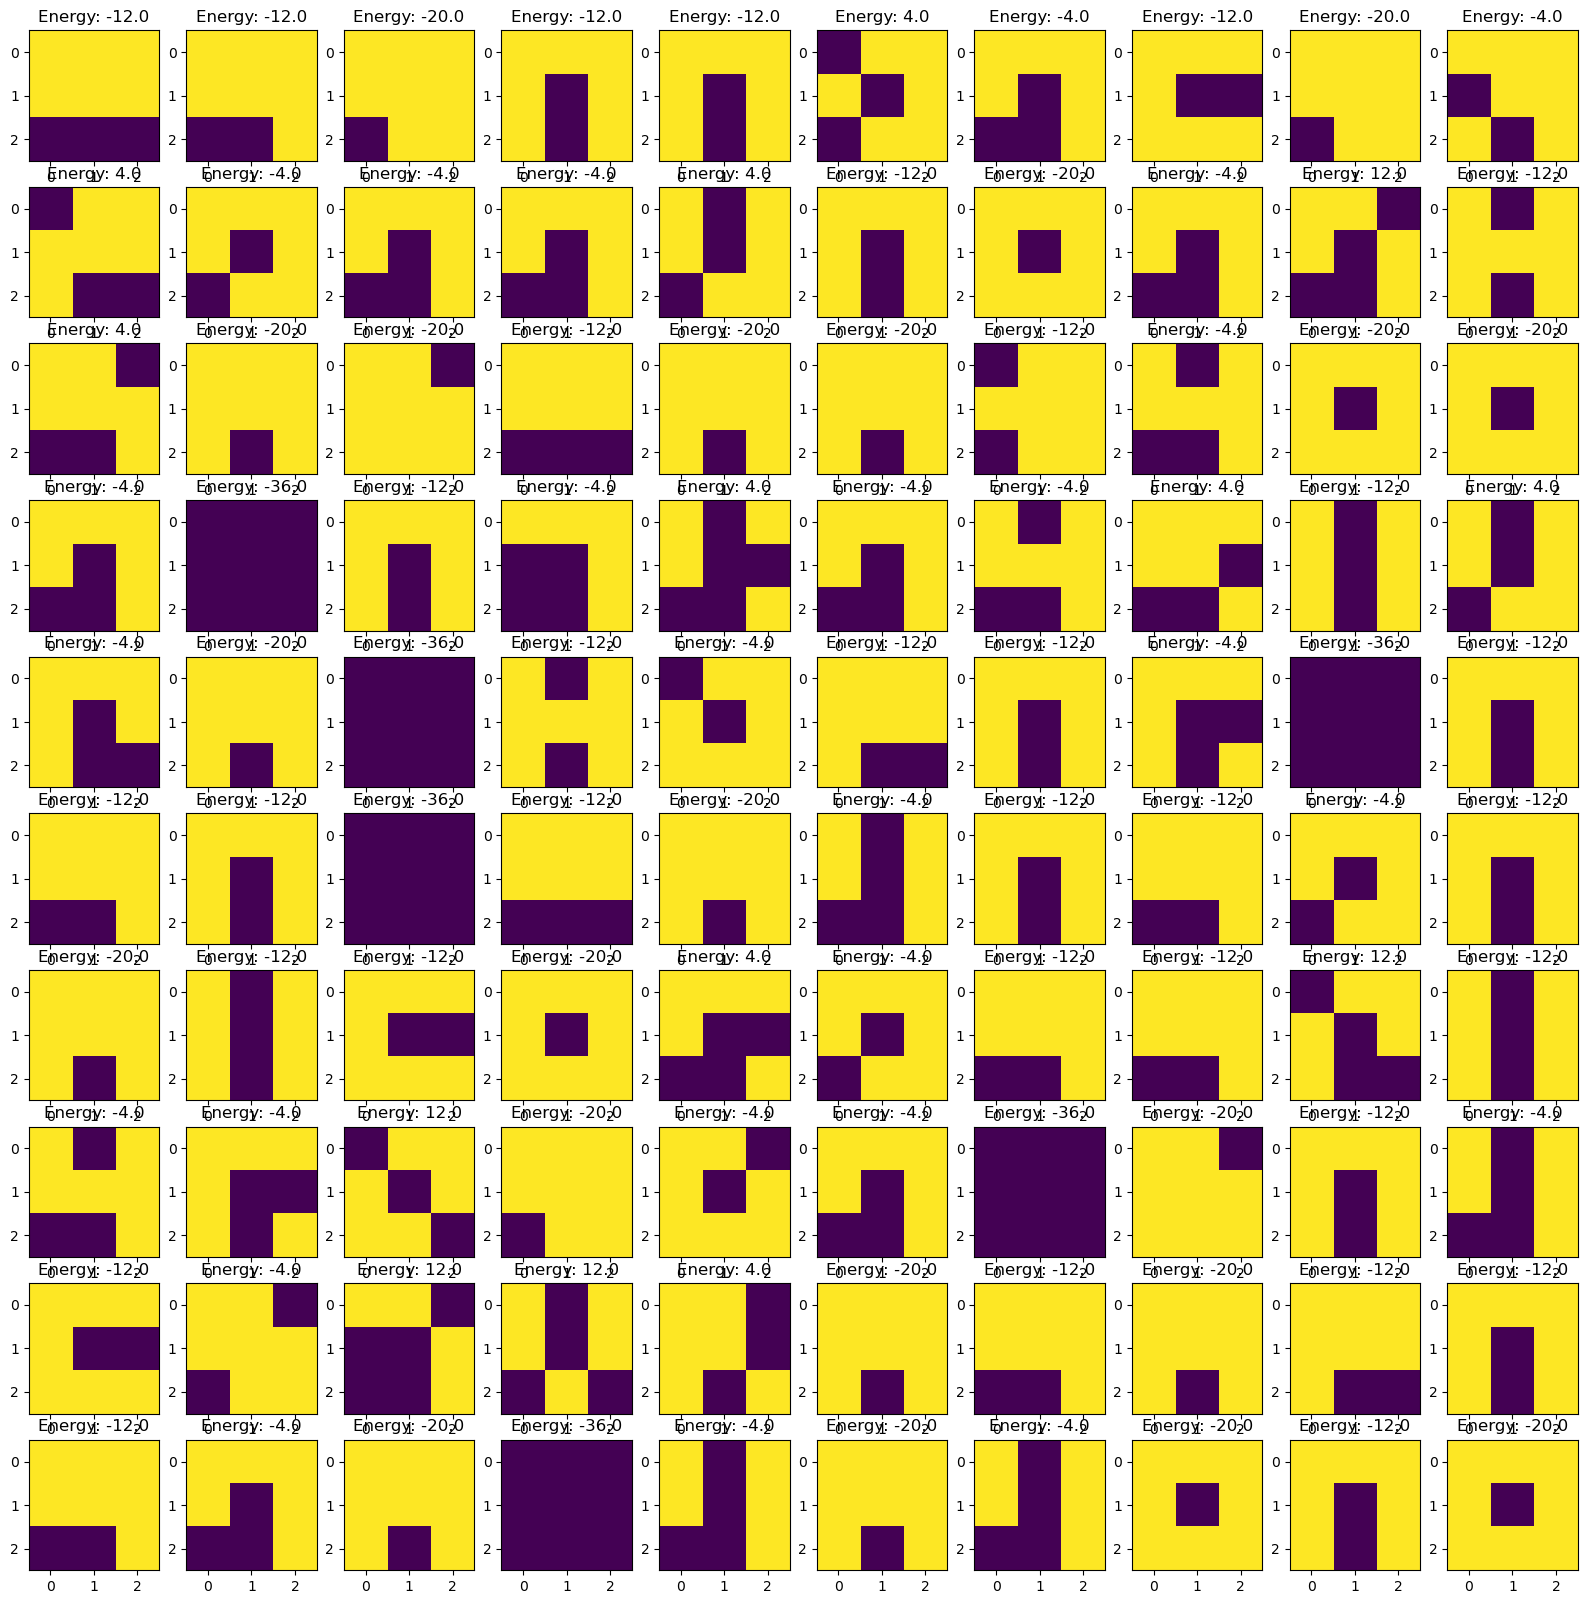

In [21]:
state = create_input_batch(N=N, batch_size=100)

for _ in range(N**2):
    state = model.make_choice(state)
print(energy_model.get_reward(state))
    
spins = [state_to_spin(s) for s in state]
energies = [sp.get_energy(J) for sp in spins]

fig, axs = plt.subplots(figsize=(20, 20), ncols=10, nrows=10)
for i, sp in enumerate(spins):
    axs[i//10][i%10].imshow(sp.values)
    axs[i//10][i%10].set_title(f"Energy: {energies[i]}")

In [26]:
torch.sum(torch.stack([e < 0 for e in energies]).float())

tensor(86.)